#Pre-setting for google colab
- import Libraries & Proccess bar
- check GPU
- connect google drive for saving model

In [ ]:
# === Import Libraries ===
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torchsummary import summary


In [ ]:
pip install tqdm

In [ ]:
!nvidia-smi

Thu Mar 13 15:19:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')
# /content/drive/MyDrive/colabnotebook/deepLearning

Mounted at /content/drive


### Data prepairtion - CIFAR10
- Data Augmentation
- Data normalization

In [ ]:
# === Define Data Augmentation and Loaders ===
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(policy=transforms.autoaugment.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# debuging -- check shape
# Get a batch from the training data
inputs, labels = next(iter(trainloader))
print(f"Training data shape: {inputs.shape}")  # Should be [batch_size, 3, 32, 32]
print(f"Training label shape: {labels.shape}")
# Check data type and scaling
print(f"CIFAR-10 Training Data Type: {inputs.dtype}")  # Should be torch.float32
print(f"CIFAR-10 Training Data Range: min={inputs.min().item()}, max={inputs.max().item()}")

# Get a batch from the test data
inputs, labels = next(iter(testloader))
print(f"Test data shape: {inputs.shape}")  # Should be [batch_size, 3, 32, 32]
print(f"Test label shape: {labels.shape}")
print(f"CIFAR-10 Test Data Type: {inputs.dtype}")  # Should be torch.float32
print(f"CIFAR-10 Test Data Range: min={inputs.min().item()}, max={inputs.max().item()}")

Files already downloaded and verified
Files already downloaded and verified
Training data shape: torch.Size([128, 3, 32, 32])
Training label shape: torch.Size([128])
CIFAR-10 Training Data Type: torch.float32
CIFAR-10 Training Data Range: min=-1.9894737005233765, max=2.130864143371582
Test data shape: torch.Size([100, 3, 32, 32])
Test label shape: torch.Size([100])
CIFAR-10 Test Data Type: torch.float32
CIFAR-10 Test Data Range: min=-1.9894737005233765, max=2.130864143371582


### Define ResNet Architecture

In [ ]:
# === Define ResNet Model ===
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

### Training strategy and setting
- setting GPU
- compuite the model Parameter and printout(show number of parameter)
- SGD optimizer
- Cosine Annealing Learning rate for SGD

In [ ]:
from tqdm import tqdm

# === Training and Testing ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model = ResNet18().to(device)

# Print the model summary
summary(model, (3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=200)

# test vs train accuracy loss
train_acc_history = []
test_acc_history = []
train_loss_history = []


def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(trainloader, desc=f'Epoch {epoch}', leave=False)

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar.set_postfix({
            'Loss': f'{loss.item():.3f}',
            'Acc': f'{100.*correct/total:.3f}%'
        })

    # Store training accuracy and loss after epoch ends
    train_acc = 100. * correct / total
    train_acc_history.append(train_acc)
    train_loss_history.append(total_loss / len(trainloader))

    print(f"Epoch {epoch} completed. Training Accuracy: {train_acc:.3f}%")

def test(epoch):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        progress_bar = tqdm(testloader, desc=f'Test Epoch {epoch}', leave=False)
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            progress_bar.set_postfix({'Acc': f'{100.*correct/total:.3f}%'})

    test_acc = 100. * correct / total
    test_acc_history.append(test_acc)

    print(f'Test Accuracy after epoch {epoch}: {test_acc:.3f}%')

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy():
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(test_acc_history, label='Test Accuracy')
    plt.title('Training vs Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

### Track Training
- print training and testing accuracy throught each epoch(show accuracy)

In [ ]:
# === Run Training ===
EPOCHS = 200
for epoch in range(EPOCHS):
    train(epoch)
    test(epoch)
    scheduler.step()

Epoch 0 completed. Training Accuracy: 25.092%


Test Accuracy after epoch 0: 39.710%


Epoch 1 completed. Training Accuracy: 41.776%


Test Accuracy after epoch 1: 51.520%


Epoch 2 completed. Training Accuracy: 53.238%


Test Accuracy after epoch 2: 56.030%


Epoch 3 completed. Training Accuracy: 60.766%


Test Accuracy after epoch 3: 67.000%


Epoch 4 completed. Training Accuracy: 66.200%


Test Accuracy after epoch 4: 66.290%


Epoch 5 completed. Training Accuracy: 69.846%


Test Accuracy after epoch 5: 76.160%


Epoch 6 completed. Training Accuracy: 72.492%


Test Accuracy after epoch 6: 76.800%


Epoch 7 completed. Training Accuracy: 74.250%


Test Accuracy after epoch 7: 78.090%


Epoch 8 completed. Training Accuracy: 75.634%


Test Accuracy after epoch 8: 80.130%


Epoch 9 completed. Training Accuracy: 77.192%


Test Accuracy after epoch 9: 82.170%


Epoch 10 completed. Training Accuracy: 77.762%


Test Accuracy after epoch 10: 81.780%


Epoch 11 completed. Training Accuracy: 78.850%


Test Accuracy after epoch 11: 83.970%


Epoch 12 completed. Training Accuracy: 79.270%


Test Accuracy after epoch 12: 83.690%


Epoch 13 completed. Training Accuracy: 80.262%


Test Accuracy after epoch 13: 82.970%


Epoch 14 completed. Training Accuracy: 80.782%


Test Accuracy after epoch 14: 85.230%


Epoch 15 completed. Training Accuracy: 81.394%


Test Accuracy after epoch 15: 82.840%


Epoch 16 completed. Training Accuracy: 81.682%


Test Accuracy after epoch 16: 85.840%


Epoch 17 completed. Training Accuracy: 82.044%


Test Accuracy after epoch 17: 86.020%


Epoch 18 completed. Training Accuracy: 82.540%


Test Accuracy after epoch 18: 86.890%


Epoch 19 completed. Training Accuracy: 83.048%


Test Accuracy after epoch 19: 85.570%


Epoch 20 completed. Training Accuracy: 83.168%


Test Accuracy after epoch 20: 84.770%


Epoch 21 completed. Training Accuracy: 83.756%


Test Accuracy after epoch 21: 86.020%


Epoch 22 completed. Training Accuracy: 83.756%


Test Accuracy after epoch 22: 88.160%


Epoch 23 completed. Training Accuracy: 84.088%


Test Accuracy after epoch 23: 86.810%


Epoch 24 completed. Training Accuracy: 84.462%


Test Accuracy after epoch 24: 85.880%


Epoch 25 completed. Training Accuracy: 84.616%


Test Accuracy after epoch 25: 87.180%


Epoch 26 completed. Training Accuracy: 84.880%


Test Accuracy after epoch 26: 86.580%


Epoch 27 completed. Training Accuracy: 85.124%


Test Accuracy after epoch 27: 86.470%


Epoch 28 completed. Training Accuracy: 85.182%


Test Accuracy after epoch 28: 85.820%


Epoch 29 completed. Training Accuracy: 85.466%


Test Accuracy after epoch 29: 87.490%


Epoch 30 completed. Training Accuracy: 85.616%


Test Accuracy after epoch 30: 86.450%


Epoch 31 completed. Training Accuracy: 85.652%


Test Accuracy after epoch 31: 88.150%


Epoch 32 completed. Training Accuracy: 85.656%


Test Accuracy after epoch 32: 87.360%


Epoch 33 completed. Training Accuracy: 85.864%


Test Accuracy after epoch 33: 86.970%


Epoch 34 completed. Training Accuracy: 86.210%


Test Accuracy after epoch 34: 88.840%


Epoch 35 completed. Training Accuracy: 86.332%


Test Accuracy after epoch 35: 87.810%


Epoch 36 completed. Training Accuracy: 86.182%


Test Accuracy after epoch 36: 88.510%


Epoch 37 completed. Training Accuracy: 86.810%


Test Accuracy after epoch 37: 88.410%


Epoch 38 completed. Training Accuracy: 86.970%


Test Accuracy after epoch 38: 88.010%


Epoch 39 completed. Training Accuracy: 86.576%


Test Accuracy after epoch 39: 87.630%


Epoch 40 completed. Training Accuracy: 86.886%


Test Accuracy after epoch 40: 89.180%


Epoch 41 completed. Training Accuracy: 86.986%


Test Accuracy after epoch 41: 88.100%


Epoch 42 completed. Training Accuracy: 87.026%


Test Accuracy after epoch 42: 90.100%


Epoch 43 completed. Training Accuracy: 87.282%


Test Accuracy after epoch 43: 87.670%


Epoch 44 completed. Training Accuracy: 87.220%


Test Accuracy after epoch 44: 89.290%


Epoch 45 completed. Training Accuracy: 87.448%


Test Accuracy after epoch 45: 88.590%


Epoch 46 completed. Training Accuracy: 87.514%


Test Accuracy after epoch 46: 89.740%


Epoch 47 completed. Training Accuracy: 87.586%


Test Accuracy after epoch 47: 89.110%


Epoch 48 completed. Training Accuracy: 87.742%


Test Accuracy after epoch 48: 88.770%


Epoch 49 completed. Training Accuracy: 88.022%


Test Accuracy after epoch 49: 87.480%


Epoch 50 completed. Training Accuracy: 87.942%


Test Accuracy after epoch 50: 88.700%


Epoch 51 completed. Training Accuracy: 87.996%


Test Accuracy after epoch 51: 88.500%


Epoch 52 completed. Training Accuracy: 88.074%


Test Accuracy after epoch 52: 89.060%


Epoch 53 completed. Training Accuracy: 88.190%


Test Accuracy after epoch 53: 89.220%


Epoch 54 completed. Training Accuracy: 88.252%


Test Accuracy after epoch 54: 89.950%


Epoch 55 completed. Training Accuracy: 88.392%


Test Accuracy after epoch 55: 88.570%


Epoch 56 completed. Training Accuracy: 88.300%


Test Accuracy after epoch 56: 89.220%


Epoch 57 completed. Training Accuracy: 88.332%


Test Accuracy after epoch 57: 90.960%


Epoch 58 completed. Training Accuracy: 88.672%


Test Accuracy after epoch 58: 89.710%


Epoch 59 completed. Training Accuracy: 88.764%


Test Accuracy after epoch 59: 87.980%


Epoch 60 completed. Training Accuracy: 88.794%


Test Accuracy after epoch 60: 90.850%


Epoch 61 completed. Training Accuracy: 88.764%


Test Accuracy after epoch 61: 90.460%


Epoch 62 completed. Training Accuracy: 88.938%


Test Accuracy after epoch 62: 89.070%


Epoch 63 completed. Training Accuracy: 88.948%


Test Accuracy after epoch 63: 90.770%


Epoch 64 completed. Training Accuracy: 89.552%


Test Accuracy after epoch 64: 89.730%


Epoch 65 completed. Training Accuracy: 89.332%


Test Accuracy after epoch 65: 90.460%


Epoch 66 completed. Training Accuracy: 89.262%


Test Accuracy after epoch 66: 91.000%


Epoch 67 completed. Training Accuracy: 89.302%


Test Accuracy after epoch 67: 90.750%


Epoch 68 completed. Training Accuracy: 89.292%


Test Accuracy after epoch 68: 87.180%


Epoch 69 completed. Training Accuracy: 89.542%


Test Accuracy after epoch 69: 89.760%


Epoch 70 completed. Training Accuracy: 89.744%


Test Accuracy after epoch 70: 90.630%


Epoch 71 completed. Training Accuracy: 89.600%


Test Accuracy after epoch 71: 90.990%


Epoch 72 completed. Training Accuracy: 89.398%


Test Accuracy after epoch 72: 88.890%


Epoch 73 completed. Training Accuracy: 89.802%


Test Accuracy after epoch 73: 90.340%


Epoch 74 completed. Training Accuracy: 89.946%


Test Accuracy after epoch 74: 90.730%


Epoch 75 completed. Training Accuracy: 89.804%


Test Accuracy after epoch 75: 90.860%


Epoch 76 completed. Training Accuracy: 90.018%


Test Accuracy after epoch 76: 91.150%


Epoch 77 completed. Training Accuracy: 89.966%


Test Accuracy after epoch 77: 89.360%


Epoch 78 completed. Training Accuracy: 90.330%


Test Accuracy after epoch 78: 91.440%


Epoch 79 completed. Training Accuracy: 90.342%


Test Accuracy after epoch 79: 90.650%


Epoch 80 completed. Training Accuracy: 90.376%


Test Accuracy after epoch 80: 91.080%


Epoch 81 completed. Training Accuracy: 90.330%


Test Accuracy after epoch 81: 91.150%


Epoch 82 completed. Training Accuracy: 90.582%


Test Accuracy after epoch 82: 91.330%


Epoch 83 completed. Training Accuracy: 90.406%


Test Accuracy after epoch 83: 91.260%


Epoch 84 completed. Training Accuracy: 90.596%


Test Accuracy after epoch 84: 90.190%


Epoch 85 completed. Training Accuracy: 90.590%


Test Accuracy after epoch 85: 91.480%


Epoch 86 completed. Training Accuracy: 90.364%


Test Accuracy after epoch 86: 91.040%


Epoch 87 completed. Training Accuracy: 90.692%


Test Accuracy after epoch 87: 90.830%


Epoch 88 completed. Training Accuracy: 90.980%


Test Accuracy after epoch 88: 91.180%


Epoch 89 completed. Training Accuracy: 90.692%


Test Accuracy after epoch 89: 91.560%


Epoch 90 completed. Training Accuracy: 90.828%


Test Accuracy after epoch 90: 91.070%


Epoch 91 completed. Training Accuracy: 91.038%


Test Accuracy after epoch 91: 90.680%


Epoch 92 completed. Training Accuracy: 91.112%


Test Accuracy after epoch 92: 91.420%


Epoch 93 completed. Training Accuracy: 91.238%


Test Accuracy after epoch 93: 91.020%


Epoch 94 completed. Training Accuracy: 91.282%


Test Accuracy after epoch 94: 90.900%


Epoch 95 completed. Training Accuracy: 91.234%


Test Accuracy after epoch 95: 91.230%


Epoch 96 completed. Training Accuracy: 91.358%


Test Accuracy after epoch 96: 90.920%


Epoch 97 completed. Training Accuracy: 91.268%


Test Accuracy after epoch 97: 92.110%


Epoch 98 completed. Training Accuracy: 91.544%


Test Accuracy after epoch 98: 90.690%


Epoch 99 completed. Training Accuracy: 91.462%


Test Accuracy after epoch 99: 91.930%


Epoch 100 completed. Training Accuracy: 91.818%


Test Accuracy after epoch 100: 91.550%


Epoch 101 completed. Training Accuracy: 91.762%


Test Accuracy after epoch 101: 91.770%


Epoch 102 completed. Training Accuracy: 91.770%


Test Accuracy after epoch 102: 91.490%


Epoch 103 completed. Training Accuracy: 91.842%


Test Accuracy after epoch 103: 91.770%


Epoch 104 completed. Training Accuracy: 92.100%


Test Accuracy after epoch 104: 92.630%


Epoch 105 completed. Training Accuracy: 91.910%


Test Accuracy after epoch 105: 91.890%


Epoch 106 completed. Training Accuracy: 92.092%


Test Accuracy after epoch 106: 91.920%


Epoch 107 completed. Training Accuracy: 92.054%


Test Accuracy after epoch 107: 91.770%


Epoch 108 completed. Training Accuracy: 92.136%


Test Accuracy after epoch 108: 92.050%


Epoch 109 completed. Training Accuracy: 92.292%


Test Accuracy after epoch 109: 91.750%


Epoch 110 completed. Training Accuracy: 92.424%


Test Accuracy after epoch 110: 92.070%


Epoch 111 completed. Training Accuracy: 92.574%


Test Accuracy after epoch 111: 91.510%


Epoch 112 completed. Training Accuracy: 92.322%


Test Accuracy after epoch 112: 91.890%


Epoch 113 completed. Training Accuracy: 92.608%


Test Accuracy after epoch 113: 92.100%


Epoch 114 completed. Training Accuracy: 92.654%


Test Accuracy after epoch 114: 92.500%


Epoch 115 completed. Training Accuracy: 92.868%


Test Accuracy after epoch 115: 91.510%


Epoch 116 completed. Training Accuracy: 92.862%


Test Accuracy after epoch 116: 92.290%


Epoch 117 completed. Training Accuracy: 92.830%


Test Accuracy after epoch 117: 92.550%


Epoch 118 completed. Training Accuracy: 92.880%


Test Accuracy after epoch 118: 92.310%


Epoch 119 completed. Training Accuracy: 93.308%


Test Accuracy after epoch 119: 92.510%


Epoch 120 completed. Training Accuracy: 93.400%


Test Accuracy after epoch 120: 92.110%


Epoch 121 completed. Training Accuracy: 93.210%


Test Accuracy after epoch 121: 92.510%


Epoch 122 completed. Training Accuracy: 93.442%


Test Accuracy after epoch 122: 92.130%


Epoch 123 completed. Training Accuracy: 93.468%


Test Accuracy after epoch 123: 93.200%


Epoch 124 completed. Training Accuracy: 93.472%


Test Accuracy after epoch 124: 92.660%


Epoch 125 completed. Training Accuracy: 93.554%


Test Accuracy after epoch 125: 92.570%


Epoch 126 completed. Training Accuracy: 93.542%


Test Accuracy after epoch 126: 92.820%


Epoch 127 completed. Training Accuracy: 93.720%


Test Accuracy after epoch 127: 92.650%


Epoch 128 completed. Training Accuracy: 93.692%


Test Accuracy after epoch 128: 92.740%


Epoch 129 completed. Training Accuracy: 93.852%


Test Accuracy after epoch 129: 93.170%


Epoch 130 completed. Training Accuracy: 93.948%


Test Accuracy after epoch 130: 92.640%


Epoch 131 completed. Training Accuracy: 93.812%


Test Accuracy after epoch 131: 92.430%


Epoch 132 completed. Training Accuracy: 94.084%


Test Accuracy after epoch 132: 92.960%


Epoch 133 completed. Training Accuracy: 93.984%


Test Accuracy after epoch 133: 92.490%


Epoch 134 completed. Training Accuracy: 94.196%


Test Accuracy after epoch 134: 93.300%


Epoch 135 completed. Training Accuracy: 94.142%


Test Accuracy after epoch 135: 92.780%


Epoch 136 completed. Training Accuracy: 94.210%


Test Accuracy after epoch 136: 93.220%


Epoch 137 completed. Training Accuracy: 94.386%


Test Accuracy after epoch 137: 93.530%


Epoch 138 completed. Training Accuracy: 94.686%


Test Accuracy after epoch 138: 92.590%


Epoch 139 completed. Training Accuracy: 94.892%


Test Accuracy after epoch 139: 93.070%


Epoch 140 completed. Training Accuracy: 94.678%


Test Accuracy after epoch 140: 92.870%


Epoch 141 completed. Training Accuracy: 94.666%


Test Accuracy after epoch 141: 93.650%


Epoch 142 completed. Training Accuracy: 94.922%


Test Accuracy after epoch 142: 93.270%


Epoch 143 completed. Training Accuracy: 94.988%


Test Accuracy after epoch 143: 93.520%


Epoch 144 completed. Training Accuracy: 94.956%


Test Accuracy after epoch 144: 93.350%


Epoch 145 completed. Training Accuracy: 95.076%


Test Accuracy after epoch 145: 93.060%


Epoch 146 completed. Training Accuracy: 95.126%


Test Accuracy after epoch 146: 93.610%


Epoch 147 completed. Training Accuracy: 95.102%


Test Accuracy after epoch 147: 93.430%


Epoch 148 completed. Training Accuracy: 95.562%


Test Accuracy after epoch 148: 93.660%


Epoch 149 completed. Training Accuracy: 95.336%


Test Accuracy after epoch 149: 93.590%


Epoch 150 completed. Training Accuracy: 95.396%


Test Accuracy after epoch 150: 93.850%


Epoch 151 completed. Training Accuracy: 95.602%


Test Accuracy after epoch 151: 93.980%


Epoch 152 completed. Training Accuracy: 95.586%


Test Accuracy after epoch 152: 93.830%


Epoch 153 completed. Training Accuracy: 95.678%


Test Accuracy after epoch 153: 94.240%


Epoch 154 completed. Training Accuracy: 95.746%


Test Accuracy after epoch 154: 93.690%


Epoch 155 completed. Training Accuracy: 95.744%


Test Accuracy after epoch 155: 93.800%


Epoch 156 completed. Training Accuracy: 95.878%


Test Accuracy after epoch 156: 94.030%


Epoch 157 completed. Training Accuracy: 95.920%


Test Accuracy after epoch 157: 94.440%


Epoch 158 completed. Training Accuracy: 96.038%


Test Accuracy after epoch 158: 94.070%


Epoch 159 completed. Training Accuracy: 96.044%


Test Accuracy after epoch 159: 94.180%


Epoch 160 completed. Training Accuracy: 95.972%


Test Accuracy after epoch 160: 94.000%


Epoch 161 completed. Training Accuracy: 96.184%


Test Accuracy after epoch 161: 94.170%


Epoch 162 completed. Training Accuracy: 96.146%


Test Accuracy after epoch 162: 93.890%


Epoch 163 completed. Training Accuracy: 96.204%


Test Accuracy after epoch 163: 94.280%


Epoch 164 completed. Training Accuracy: 96.456%


Test Accuracy after epoch 164: 94.340%


Epoch 165 completed. Training Accuracy: 96.436%


Test Accuracy after epoch 165: 94.290%


Epoch 166 completed. Training Accuracy: 96.440%


Test Accuracy after epoch 166: 94.270%


Epoch 167 completed. Training Accuracy: 96.520%


Test Accuracy after epoch 167: 94.390%


Epoch 168 completed. Training Accuracy: 96.524%


Test Accuracy after epoch 168: 94.240%


Epoch 169 completed. Training Accuracy: 96.574%


Test Accuracy after epoch 169: 94.300%


Epoch 170 completed. Training Accuracy: 96.364%


Test Accuracy after epoch 170: 94.320%


Epoch 171 completed. Training Accuracy: 96.676%


Test Accuracy after epoch 171: 94.470%


Epoch 172 completed. Training Accuracy: 96.626%


Test Accuracy after epoch 172: 94.410%


Epoch 173 completed. Training Accuracy: 96.748%


Test Accuracy after epoch 173: 94.710%


Epoch 174 completed. Training Accuracy: 96.796%


Test Accuracy after epoch 174: 94.340%


Epoch 175 completed. Training Accuracy: 96.574%


Test Accuracy after epoch 175: 94.340%


Epoch 176 completed. Training Accuracy: 96.782%


Test Accuracy after epoch 176: 94.430%


Epoch 177 completed. Training Accuracy: 96.854%


Test Accuracy after epoch 177: 94.580%


Epoch 178 completed. Training Accuracy: 96.906%


Test Accuracy after epoch 178: 94.490%


Epoch 179 completed. Training Accuracy: 96.914%


Test Accuracy after epoch 179: 94.590%


Epoch 180 completed. Training Accuracy: 96.910%


Test Accuracy after epoch 180: 94.590%


Epoch 181 completed. Training Accuracy: 96.968%


Test Accuracy after epoch 181: 94.520%


Epoch 182 completed. Training Accuracy: 97.140%


Test Accuracy after epoch 182: 94.770%


Epoch 183 completed. Training Accuracy: 96.960%


Test Accuracy after epoch 183: 94.700%


Epoch 184 completed. Training Accuracy: 97.138%


Test Accuracy after epoch 184: 94.760%


Epoch 185 completed. Training Accuracy: 96.932%


Test Accuracy after epoch 185: 94.800%


Epoch 186 completed. Training Accuracy: 96.988%


Test Accuracy after epoch 186: 94.690%


Epoch 187 completed. Training Accuracy: 97.004%


Test Accuracy after epoch 187: 94.870%


Epoch 188 completed. Training Accuracy: 97.150%


Test Accuracy after epoch 188: 94.810%


Epoch 189 completed. Training Accuracy: 97.000%


Test Accuracy after epoch 189: 94.820%


Epoch 190 completed. Training Accuracy: 97.090%


Test Accuracy after epoch 190: 94.750%


Epoch 191 completed. Training Accuracy: 97.136%


Test Accuracy after epoch 191: 94.670%


Epoch 192 completed. Training Accuracy: 97.172%


Test Accuracy after epoch 192: 94.640%


Epoch 193 completed. Training Accuracy: 97.042%


Test Accuracy after epoch 193: 94.730%


Epoch 194 completed. Training Accuracy: 97.098%


Test Accuracy after epoch 194: 94.760%


Epoch 195 completed. Training Accuracy: 97.240%


Test Accuracy after epoch 195: 94.730%


Epoch 196 completed. Training Accuracy: 97.110%


Test Accuracy after epoch 196: 94.710%


Epoch 197 completed. Training Accuracy: 97.308%


Test Accuracy after epoch 197: 94.700%


Epoch 198 completed. Training Accuracy: 97.158%


Test Accuracy after epoch 198: 94.750%


Epoch 199 completed. Training Accuracy: 97.134%


Test Accuracy after epoch 199: 94.720%


### Training Accuracy vs Test Accuracy plot(showing plot)

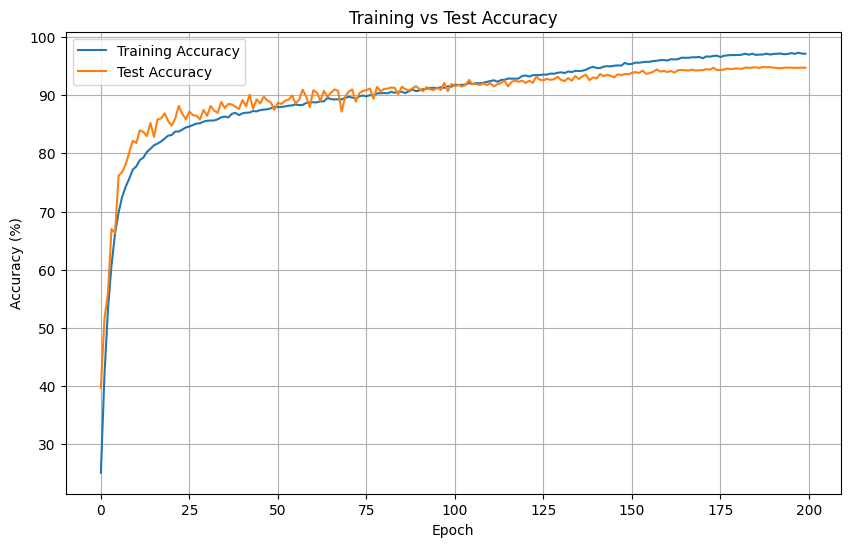

In [ ]:
# Plot after training ends
plot_accuracy()

### Saving model

In [ ]:
# === Save the Model to Google Drive ===
torch.save(model.state_dict(), '/content/drive/MyDrive/colabnotebook/deepLearning/result2.pth')
print("Model saved to Google Drive.")


Model saved to Google Drive.


### Predict costume test Dataset with save Model
- Import Library
- Preview test dataset
- Load saving model
- Load test dataset
- Make Prediction
- Save result in CSV formate

In [ ]:
import torch
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pickle
import matplotlib.pyplot as plt

# ==== Step 1: Load the Model ====
from torchvision import models


- Preview test dataset

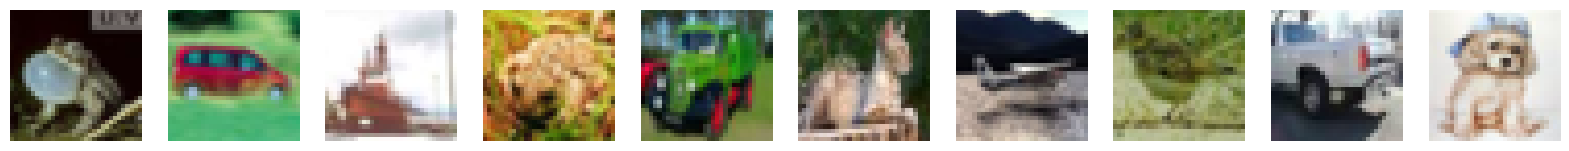

In [ ]:
# Load the test data
def load_cifar_batch(file):
    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

# Load the batch
test_file_path = '/content/drive/MyDrive/colabnotebook/deepLearning/cifar_test_nolabel.pkl'
cifar10_batch = load_cifar_batch(test_file_path)

# Extract images (N, 32, 32, 3)
images = cifar10_batch[b'data']

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.show()

Load saving model

In [ ]:
# Define the model architecture (same as the one used for training)
model = ResNet18()
model.load_state_dict(torch.load('/content/drive/MyDrive/colabnotebook/deepLearning/result2.pth'))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

<ipython-input-30-4b5c2cd10fd8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/colabnotebook/deepLearning/result.p

- Load test dataset

In [ ]:
# ==== Step 2: Load and Prepare Test Dataset ====
class CIFAR10TestDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data[b'data']     # Directly extract images (N, 32, 32, 3)
        self.ids = list(range(len(self.data)))  # Create IDs based on index
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]  # Shape: (32, 32, 3)

        # === Debug: Check shape ===
        # print(f"Original shape: {image.shape}")

        # Permute dimensions to (3, 32, 32) for PyTorch format
        # Scale values to [0, 1] range
        image = torch.tensor(image).permute(2, 0, 1).float() / 255.0

        # === Add Debugging Code ===
        # print(f"Sample {idx}: min={image.min().item()}, max={image.max().item()}")
        # print(f"Sample {idx}: dtype={image.dtype}")

        if self.transform:
            image = self.transform(image)
            # Check shape -- Add Debugging AFTER normalization
            print(f"Sample {idx} AFTER normalization: min={image.min().item()}, max={image.max().item()}")
            print(f"Sample {idx} AFTER normalization: dtype={image.dtype}")

        return image, self.ids[idx]



# Load test data
test_file_path = '/content/drive/MyDrive/colabnotebook/deepLearning/cifar_test_nolabel.pkl'
with open(test_file_path, 'rb') as f:
    test_data = pickle.load(f)

# Define the same transforms as used in training
transform = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

test_dataset = CIFAR10TestDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# debugging check data shape
inputs, ids = next(iter(test_loader))
print(f"Custom Test data shape: {inputs.shape}")
print(f"Custom Test ID shape: {ids.shape}")


Sample 0 AFTER normalization: min=-1.9843621253967285, max=1.57978355884552
Sample 0 AFTER normalization: dtype=torch.float32
Sample 1 AFTER normalization: min=-1.9894737005233765, max=1.5647584199905396
Sample 1 AFTER normalization: dtype=torch.float32
Sample 2 AFTER normalization: min=-0.9676591157913208, max=2.130864143371582
Sample 2 AFTER normalization: dtype=torch.float32
Sample 3 AFTER normalization: min=-1.8942129611968994, max=2.0591094493865967
Sample 3 AFTER normalization: dtype=torch.float32
Sample 4 AFTER normalization: min=-1.9894737005233765, max=1.8844646215438843
Sample 4 AFTER normalization: dtype=torch.float32
Sample 5 AFTER normalization: min=-1.862459421157837, max=2.0432324409484863
Sample 5 AFTER normalization: dtype=torch.float32
Sample 6 AFTER normalization: min=-1.9894737005233765, max=2.130864143371582
Sample 6 AFTER normalization: dtype=torch.float32
Sample 7 AFTER normalization: min=-1.7107279300689697, max=1.1787137985229492
Sample 7 AFTER normalization: d

- Make Prediction

In [ ]:
# ==== Step 3: Make Predictions ====
predictions = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            predictions.append((ids[i].item(), predicted[i].item()))

- Save result in CSV formate

In [ ]:
# ==== Step 4: Save Predictions as CSV ====
df = pd.DataFrame(predictions, columns=["ID", "Labels"])
output_path = '/content/drive/MyDrive/colabnotebook/deepLearning/cifar10_predictions2.csv'
df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")

Predictions saved to /content/drive/MyDrive/colabnotebook/deepLearning/cifar10_predictions2.csv
